## Wine Classification using Logistic Regression
    Auteur : Thierry SANDOZ and Stephen MONNET                        
    Date : 10.06.2020 
    Contenu : Réalisation d'un algorithme de régression logistique pour classifier les différents vins blancs

## Imported librairies and configurations

In [1]:
from sys import path
path.append('functions')
from WineClassificationLib import distribution

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import scipy.io as sio
import seaborn as sns

## Normalization 
from sklearn import preprocessing

## Mathematical functions
import math                # for exp()

## Optimizing a function
import scipy.optimize as opt

# PCA (principal component analysis)
from sklearn.decomposition import PCA

# Normalization 
from sklearn import preprocessing

# Data separation 
from sklearn.model_selection import train_test_split

### Import personal functions

In [2]:
from sys import path
path.append('functions')
from WineClassificationLib import learningCurveLR
from WineClassificationLib import sigmoid
from WineClassificationLib import costFunctionLR
from WineClassificationLib import gradFunctionLR

## Ouverture des fichiers + Prétraitement des données
Les données sont enregistrées en format csv et celles-ci sont séparées par des ';'. La fonction read_csv de Pandas permet directement d'ouvrir un fichier et de stocker les différentes données sous forme de tableau. Le tableau présent ci-dessous permet de visualiser un aperçu du contenu des ces données. Le prétraitement des données est détaillé dans le fichier WineClassification.ipynb

In [3]:
dataWine = pd.read_csv("data/winequality-white.csv", sep=';')

## Affichage des 5 premières lignes de données
display(dataWine.head(n=5))

## Affichage du nombre de données
nb_data = len(dataWine)
print('Le nombre de données présentes dans le fichier (taille du dataset) est de :', nb_data)

## Séparation des données en différentes classes : 1, 2, 3, 4 = mauvais, 5 = assez bon, 6 = bon, 7 = très bon, 8, 9, 10 => excellent
bins = [3,4,5,6,7,9]
quality_labels=[0,1,2,3,4]
num_labels = len(quality_labels) ## Number of labels
dataWine['quality_categorical'] = pd.cut(dataWine['quality'], bins=bins, labels=quality_labels, include_lowest=True)

# For each feature find the data points with extreme high or low values
outliers = []
features_raw = dataWine.drop(['quality', 'quality_categorical'], axis = 1)
quality_raw = dataWine['quality_categorical']

for feature in features_raw.keys():

    Q1 = np.percentile(features_raw[feature], q=25)

    Q3 = np.percentile(features_raw[feature], q=75)
    
    interquartile_range = Q3 - Q1
    step = 1.5 * interquartile_range
    
    #print("Data points considered outliers for the feature '{}':".format(feature))
    #display(dataWine[~((dataWine[feature] >= Q1 - step) & (dataWine[feature] <= Q3 + step))])

    outliers = outliers + list(features_raw[~((features_raw[feature] >= Q1 - step) & (features_raw[feature] <= Q3 + step))].index)
    
    # Remove the outliers, if any were specified
    good_data = features_raw.drop(features_raw.index[outliers]).reset_index(drop = True)
    good_quality = quality_raw.drop(quality_raw.index[outliers]).reset_index(drop = True)
    
print("Nb data before removing the outliers :", len(dataWine))
print("Nb data after removing the outliers :", len(good_data))

## Normalize the features between 0 and 1
x = good_data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
good_data = pd.DataFrame(x_scaled, columns=good_data.columns)

## Diplay the first five row of the datas
display(good_data.head(n=5))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Le nombre de données présentes dans le fichier (taille du dataset) est de : 4898
Nb data before removing the outliers : 4898
Nb data after removing the outliers : 4011


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.550,0.469136,0.553191,0.939252,0.527273,0.551282,0.636752,0.935354,0.232877,0.425926,0.068966
1,0.375,0.543210,0.510638,0.046729,0.600000,0.153846,0.474359,0.463973,0.643836,0.500000,0.189655
2,0.825,0.493827,0.638298,0.294393,0.618182,0.358974,0.324786,0.538047,0.589041,0.407407,0.293103
3,0.600,0.370370,0.468085,0.369159,0.763636,0.576923,0.705128,0.571717,0.493151,0.333333,0.258621
4,0.600,0.370370,0.468085,0.369159,0.763636,0.576923,0.705128,0.571717,0.493151,0.333333,0.258621


### Séparation des données en 2 sets
Pour déterminer si les résultats obtenus par l'algorithme sont bons, il est important de séparer les données en 2 sets de données. Le premier est le set d'entraînement. Il représente 80% du set complet et est celui qui permet d'entraîner l'algorithme de ML. Le deuxième est un set de test qui permettra d'observer les résultats obtenus sur des données n'ayant pas été utilisée pour l'entraînement. Celui-ci représente 20% du set complet. La fonction "train_test_split" de sklearn permet de réaliser cette division en 2 sets de manière aléatoire. Dans celle-ci on peut spécifier la taille du test set.

In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(good_data, 
                                                    good_quality, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

## Convert to numpy array
X_train = np.array(X_train.values)
y_train = np.array(y_train.values)
y_train = np.squeeze(np.array([y_train])) 

X_test = np.array(X_test.values)
y_test = np.array(y_test.values)
y_test = np.squeeze(np.array([y_test])) 

Training set has 3208 samples.
Testing set has 803 samples.


### Optimization de la fonction de de coût 
Pour obtenir les thetas qui optimisent au mieux la fonction de coût, on utilise la fonction fmin_cg de scipy. Les fonctions de coût et de gradient sont présentes dans la librairie (personnelle) WineClassificationLib.py. Ces fonctions ont été testé en reprenant l'algorithme ayant été implémenté sur matlab et en comparant les résultats obtenus. Le valeur optimale du paramètre de regression lambda_reg vaut 0.001. Celle-ci a été obtenue en effectuant des essais successifs en modifiant sa valeur.

In [5]:
## Paramètre de régression
lambda_reg = 0.001

## Déclaration de variables
num_examples = X_train.shape[0]
num_features = X_train.shape[1]
classifiers = np.zeros(shape=(num_labels, num_features + 1))

## Add a column of ones to the X matrix
X_train_1 = np.ones(shape=(X_train.shape[0], X_train.shape[1] + 1))
X_train_1[:, 1:] = X_train

## Add a column of ones to the X matrix
X_test_1 = np.ones(shape=(X_test.shape[0], X_test.shape[1] + 1))
X_test_1[:, 1:] = X_test

for c in range(0, num_labels):
    label = (y_train == c).astype(int)
    initial_theta = np.zeros(X_train_1.shape[1])
    classifiers[c, :] = opt.fmin_cg(costFunctionLR, initial_theta, gradFunctionLR, (X_train_1, label, lambda_reg), disp=0)
classProbabilities = sigmoid(X_test_1 @ classifiers.transpose())

### Résultats obtenus
Les résultats obtenus en appliquant la régression logistique sur les données sont présentés ci-dessous. On observe que la précision ainsi que la matrice de confusion correspond bien à celle qui a été obtenue avec l'algorithme de sklearn présent dans le code WineClassification_data_visualisation.ipynb (chapitre "Essai préliminaire de divers algorithms de ML")

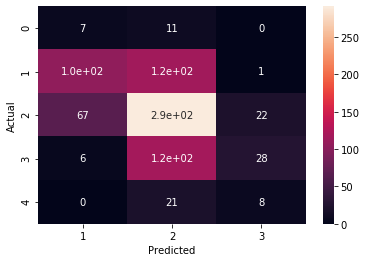

Training accuracy: 52.80199252801992%


In [6]:
## Compute the predictions
predictions = classProbabilities.argmax(axis=1)

## Plot the confusion matrix
confusion_matrix = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

print("Training accuracy:", str(100 * np.mean(predictions == y_test)) + "%")